## GANs

Neste exercício aprenderemos a desenvolver uma GAN simples utilizando Keras.

Para isto, utilizaremos um dataset fictício que gera dados bidimensionais relativamente simples, e nossa rede GAN vai tentar replicar estes dados. 

Como primeiro passo, vamos criar o código para gerar este dataset e visualizar como ele se parece.

A função fictícia irá ter 2 features. A primeira (*x*) está contida no intervalo entre \[-1, 1\]. A segunda (*y*) é dependente de *x* de acordo com a equação abaixo:

<img src="https://latex.codecogs.com/svg.latex?\Large&space;y=x^2"/>

O que faremos nesse exercício é tentar treinar uma GAN para gerar ambas as variáveis de modo realístico, com apenas a informação de que 2 variáveis devem ser geradas.

Primeiro vamos criar uma função que gere instâncias <x,y> "reais"

In [1]:
import numpy as np

def real_function(x):
    #Função que gera y real
    return np.multiply(x,x)

def generate_samples(n_samples):
    #Implemente uma função que gera <n_samples> exemplos da função descrita acima. 
    #Cada "linha" da variabel result deve conter um valor x aleatório entre [-1, 1] e seu y correspondente
    result = np.zeros((n_samples, 2))
    result[:, 0] = np.random.uniform(-1, 1, n_samples)
    result[:, 1] = real_function(result[:, 0])
    return result

training_set = generate_samples(10000)
test_set = generate_samples(10000)

training_set, training_set.shape

(array([[ 0.42746527,  0.18272656],
        [-0.54790816,  0.30020336],
        [-0.43783711,  0.19170133],
        ...,
        [ 0.62176554,  0.38659239],
        [-0.83501038,  0.69724233],
        [ 0.1339926 ,  0.01795402]]),
 (10000, 2))

Vamos também criar uma função auxiliar para ajudar na visualização dos dados:

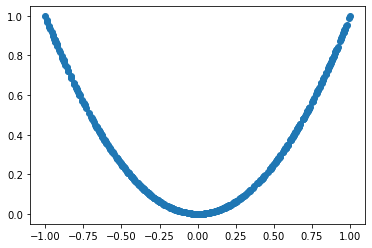

In [2]:
import matplotlib.pyplot as plt
def print_samples(data, label=None):
    plt.scatter(data[:,0], data[:, 1], label=label)
    if label: plt.legend()
    
print_samples(training_set[:500])

Agora que temos uma base de treinamento, basta montar a nossa GAN.

Relembrando o conteúdo da aula, a GAN é composta por um *discriminador* e um *gerador*. O discriminador é um classificador comum que aprende a distinguir instâncias reais de fictícias, e o gerador tenta aprender como gerar instâncias fictícias que enganem o discriminador.

Vamos então partir para a implementação do discriminador, lembrando que a entrada é bidimensional, e a saída tem apenas uma dimensão prevendo se a instância é falsa ou verdadeira.

**Dicas:** GANs não são triviais para treinar. Alguns hacks são citados aqui:
https://github.com/soumith/ganhacks
* Normalizar os inputs entre -1 e 1
* Usar tanh na última camada do gerador
* Substituir min(log 1-D) por max(log D) na função de perda (evitar vanishing gradients)
* Amostrar utilizando uma função gaussiana, não uniforme
* Evitar gradientes esparsos como ReLU e MaxPool (estabilidade da GAN)
    * algumas opções: LeakyReLU (D e G), AveragePooling e Conv2d/strided para downsampling, PixelShuffle e ConvTranspode2d/stride para upsampling
* Usar labels suavizadas adicionando uma perturbação sobre os valores 0 (fake) e 1 (real)
* Fazer flips aleatórios durante o treino do discriminador (real=fake, fake=real)
* Usar SGD para o discriminador e ADAM para o gerador
* Se os labels estão disponíveis, classificar usando a GAN auxiliar durante treino do discriminador
* Adicionar ruído aos inputs ao entrar no disciminador
* Adicionar ruído gaussiano a cada uma das camadas do gerador

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import initializers

Conforme visto na aula, o gerador é dependente do discriminador para o treinamento, e vai tentar fazer com que o discriminador erre em suas predições.

Para isto, precisamos criar um modelo *gerador* e um modelo *GAN*. O *gerador* irá partir de números aleatórios de tamanho arbitrário e tentar gerar números realísticos que sigam o padrão de nossos dados reais.

O Processo de treinamento consiste em fazer com que o discriminador falhe em sua tarefa, o que vai ser possível se o gerador criar exemplos indistinguíveis dos dados reais. Como o *gerador* necessita do *discriminador* para seu treinamento, o Keras requer criarmos um outro modelo *GAN* que vai conectar o *gerador* e *discriminador*.

Note que estamos usando a definição mais simples de custo para o gerador, o inverso do custo do discriminador.


In [22]:
def gan_discriminator_model(in_dim_D, lr=0.01, momentum=0.0):
    model = Sequential(name='discriminator')
    model.add(Input(shape=(in_dim_D,)))
    model.add(Dense(32, activation=LeakyReLU(alpha=0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation=LeakyReLU(alpha=0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=lr, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def gan_generator_model(in_dim_G, in_dim_D):
    model = Sequential(name='generator')
    model.add(Input(shape=(in_dim_G,)))
    model.add(Dense(32, activation=LeakyReLU(alpha=0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation=LeakyReLU(alpha=0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(in_dim_D, activation='tanh'))
    return model

def define_gan(generator, discriminator, in_dim_G, lr=0.001):
    discriminator.trainable = False #Não atualizar o D durante treino do G
    ganInput = Input(shape=(in_dim_G,))
    x = generator(ganInput)
    ganOutput = discriminator(x)
    gan = Model(inputs=ganInput, outputs=ganOutput, name='GAN')
    opt = Adam(lr=lr, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan


# definir a dimensão de entrada do discriminador (domínio original real)
#  e a dimensão de entrada do gerador (domínio do espaço latente)
in_dim_D, in_dim_G = 2, 5

discriminator = gan_discriminator_model(in_dim_D)
discriminator.summary()

generator = gan_generator_model(in_dim_G, in_dim_D)
generator.summary()

gan = define_gan(generator, discriminator, in_dim_G)
gan.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                96        
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
Layer (type)                 Out

Agora que temos todos os modelos definidos, podemos realizar o treinamento efetivamente.

Mas antes, vamos criar algumas funções auxiliares.

A primeira `generate_batch_discriminator` vai criar um batch para treinamento do discriminador. De acordo com os valores nos parâmetros, metade do batch conterá instâncias reais (label y = 0) e metade do batch conterá instâncias falsas (label y = 1).

In [23]:
# O discriminador deve receber amostras verdadeiras e amostras fake criadas pelo gerador treinado
#   ele precisa descobrir quem são as amostras reais e quem são as falsas

import time

def generate_batch_discriminator(batch_size, in_dim_D, in_dim_G, data, generator, noise=0.1, flip=0.05):
    start = time.time()
    half_batch = int(batch_size / 2)    
    batch = np.zeros((batch_size, in_dim_D))
    batch_y = np.zeros(batch_size)
    
    #Pega exemplos aleatoriamente da base de dados real
    random_indices = np.random.choice(len(data), size=half_batch, replace=False)
    batch[:half_batch, :] = data[random_indices, :]
    #print('Real', time.time() - start)
    #Adicionar um pequeno ruído em torno das instâncias reais, em torno de 0
    if noise != 0:
        batch_y[:half_batch] = abs(np.random.normal(0., noise, half_batch))
    else: 
        batch_y[:half_batch] = 0.
    #print('Real y', time.time() - start)
    
    # A variável aleatória de entrada do gerador vai seguir uma distribuição normal
    batch[half_batch:, :] = generator.predict(np.random.normal(0, 1, size=[half_batch, in_dim_G]))
    #print('Fake', time.time() - start)
    #Adicionar um pequeno ruído em torno das instâncias fake, em torno de 1
    if noise != 0:
        batch_y[half_batch:] = 1 - abs(np.random.normal(0., noise, half_batch))
    else:
        batch_y[half_batch:] = 1.
    #print('Fake y', time.time() - start)
    if flip > 0:
        random_indices = np.random.choice(batch_size, size=int(flip * batch_size), replace=False)
        batch_y[random_indices] = abs(1.0 - batch_y[random_indices])
    return batch, batch_y


generate_batch_discriminator(10, in_dim_D, in_dim_G, training_set, generator, noise=0.1, flip=0.1)

(array([[-5.35181078e-01,  2.86418786e-01],
        [-3.29784762e-01,  1.08757989e-01],
        [-9.09022058e-01,  8.26321101e-01],
        [ 1.87329771e-02,  3.50924433e-04],
        [-4.36348506e-01,  1.90400019e-01],
        [ 2.89551280e-02, -2.16135964e-01],
        [ 1.83471709e-01, -1.78020388e-01],
        [ 5.20984888e-01, -7.86570683e-02],
        [-1.78761519e-02, -2.29651362e-01],
        [ 2.44962975e-01,  6.56488091e-02]]),
 array([0.10661171, 0.03630132, 0.04499111, 0.156816  , 0.05403451,
        0.85777885, 0.99857232, 0.9894558 , 0.83553396, 0.93608106]))

Precisaremos também de uma função semelhante para treinar o gerador, mas o batch de treinamento deve gerar apenas valores aleatórios, que serão alimentados ao modelo `gan`.

In [24]:
def generate_batch_gan(batch_size, in_dim_G):
    x_gan = np.random.normal(0., 1., size=[batch_size, in_dim_G])
    #Neste caso criamos labels invertidos para os exemplos falsos, porque a funcao de custo
    # do gerador é o inverso do discriminador
    y_gan = np.zeros((batch_size)) 
    return x_gan, y_gan


generate_batch_gan(10, in_dim_G)

(array([[ 0.11499167,  0.25919869,  0.62169217,  0.95717678,  0.81103807],
        [-2.00302516, -0.63557324, -2.09797967,  0.26996117, -0.18842504],
        [ 0.5287026 , -1.82602844,  2.13586702, -1.29633189, -0.10515617],
        [-1.66528951,  0.30579357,  0.34914339, -0.4888521 ,  1.68424559],
        [-3.05773005, -0.41598949, -0.54307439,  0.40856833,  0.0341285 ],
        [ 1.17097683,  1.33204735, -0.15612849, -0.60747   ,  1.29624511],
        [-1.44432212,  0.43882181, -0.68272   , -0.07847706, -0.24573579],
        [ 1.34424821,  0.33371009,  0.39956593,  0.82838823, -0.63922176],
        [ 0.17038975, -0.66929508,  0.76122044, -0.25050611,  0.95953103],
        [ 2.06879416,  0.57339122,  0.88089139,  0.95241448, -1.40913184]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Agora podemos criar a função de treinamento. Primeiro rodamos uma época de treinamento em batch do discriminador, para depois rodar uma época do gerador. Periodicamente visualizamos como as instâncias geradas se parecem. Durante o treinamento também iremos guardar as funcões de custo dos modelos e o percentual de acerto do discriminador em teste.



Training status:
Epoch: 0


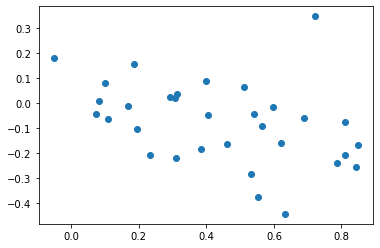

Errors Discrimin: 0.6868213415145874
Errors Generator:0.6710776090621948
Perc Discrim:0.53125


Training status:
Epoch: 1000


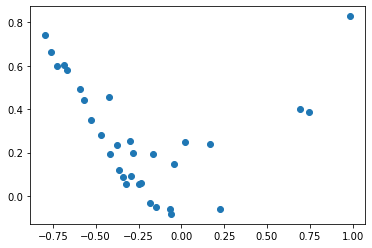

Errors Discrimin: 0.6973488926887512
Errors Generator:0.690277636051178
Perc Discrim:0.5625


Training status:
Epoch: 2000


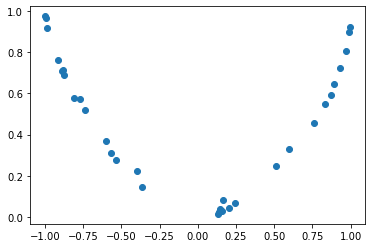

Errors Discrimin: 0.6961649656295776
Errors Generator:0.682680606842041
Perc Discrim:0.5625


Training status:
Epoch: 3000


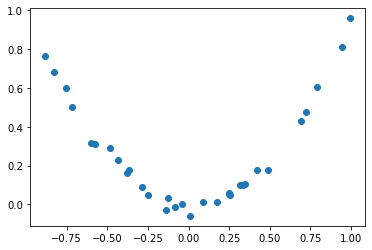

Errors Discrimin: 0.7023160457611084
Errors Generator:0.6936501264572144
Perc Discrim:0.46875


Training status:
Epoch: 4000


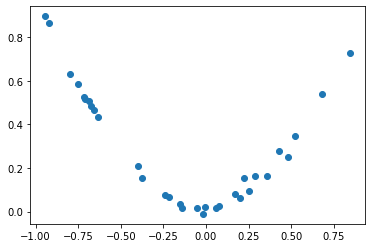

Errors Discrimin: 0.6891412138938904
Errors Generator:0.6874551773071289
Perc Discrim:0.59375


Training status:
Epoch: 5000


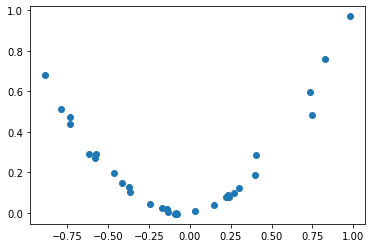

Errors Discrimin: 0.6979576349258423
Errors Generator:0.6935760974884033
Perc Discrim:0.4375


Training status:
Epoch: 6000


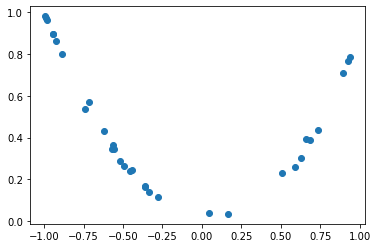

Errors Discrimin: 0.6863011121749878
Errors Generator:0.6982096433639526
Perc Discrim:0.5625


Training status:
Epoch: 7000


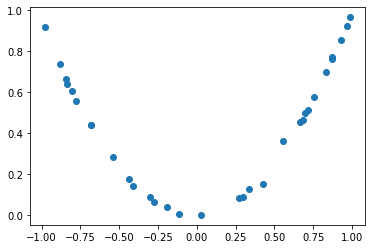

Errors Discrimin: 0.6885265111923218
Errors Generator:0.6983532905578613
Perc Discrim:0.46875


Training status:
Epoch: 8000


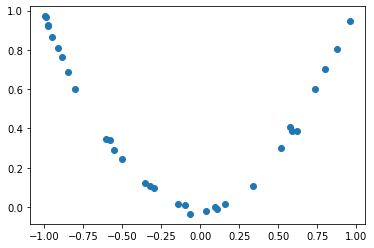

Errors Discrimin: 0.6964105367660522
Errors Generator:0.6916835308074951
Perc Discrim:0.4375


Training status:
Epoch: 9000


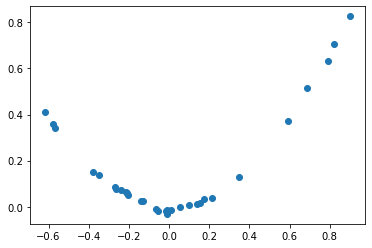

Errors Discrimin: 0.6926935911178589
Errors Generator:0.6900526881217957
Perc Discrim:0.5


In [47]:
import time

def print_images(samples):
    plt.close()
    print_samples(samples)
    plt.show()

    
batch_size = 32
test_size = 32
epochs = 10000
in_dim_D, in_dim_G = 2, 5
noise = 0.0
flip = 0.0

# Instância os modelos
discriminator = gan_discriminator_model(in_dim_D, lr=0.01, momentum=0.0)
generator = gan_generator_model(in_dim_G, in_dim_D)
gan = define_gan(generator, discriminator, in_dim_G, lr=0.001)

# Erros do discriminador e gerador, e percentual de acerto no teste
errors_discrim = np.zeros((epochs))
errors_generator = np.zeros((epochs))
perc_discrim = np.zeros((epochs))

# Utilizado para a visualização de imagens não travar o treinamento
plt.ion()

for i in range(epochs):
    
    start = time.time()
    batch, batch_y = generate_batch_discriminator(batch_size, in_dim_D, in_dim_G, training_set, generator, noise=noise, flip=flip)
    #print('\nTempos:')
    #print('Gen Batch', time.time() - start)
    discriminator.trainable = True
    errors_discrim[i], _ = discriminator.train_on_batch(batch, batch_y)    
    #print('Disc Train', time.time() - start)
    
    x_gan, y_gan = generate_batch_gan(batch_size, in_dim_G)
    #print('Gen Gan Batch', time.time() - start)
    discriminator.trainable = False
    errors_generator[i] = gan.train_on_batch(x_gan, y_gan)
    #print('GAN Train', time.time() - start)
    
    # Gera um batch de teste e calcula a acurácia do discriminador
    test_batch, test_y = generate_batch_discriminator(test_size, in_dim_D, in_dim_G, test_set, generator, noise=noise)
    #print('Test Batch', time.time() - start)
    predictions =  (discriminator.predict(test_batch).ravel() > 0.5) * 1.
    #print('Prediction', time.time() - start)
    y_true =  (test_y > 0.5) * 1.    
    perc_discrim[i] = sum(predictions == y_true) / test_size
    #print('Result', time.time() - start)
    
    # Mostrar evolução do treino periodicamente
    if i % (epochs//10) == 0:
        print("\n\nTraining status:")
        print("Epoch: "+str(i))
        print_images(generator.predict(np.random.normal(0., 1., size=[test_size, in_dim_G])))
        print("Errors Discrimin: " + str(errors_discrim[i]))
        print("Errors Generator:" + str(errors_generator[i]))
        print("Perc Discrim:" + str(perc_discrim[i]))

Após o treinamento podemos visualizar se o treino deu certo comparando os dados reais com os gerados pela GAN.

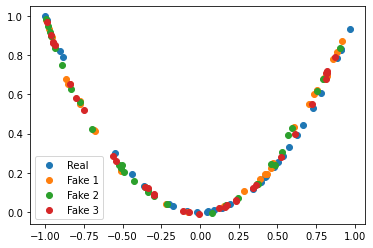

In [52]:
print_samples(training_set[:test_size,:], label='Real')
print_samples(generator.predict(np.random.normal(0, 1, size=[test_size, in_dim_G])), label='Fake 1')
print_samples(generator.predict(np.random.normal(0, 1, size=[test_size, in_dim_G])), label='Fake 2')
print_samples(generator.predict(np.random.normal(0, 1, size=[test_size, in_dim_G])), label='Fake 3')

Também podemos visualizar os erros dos modelos e o percentual de acerto do discriminador.

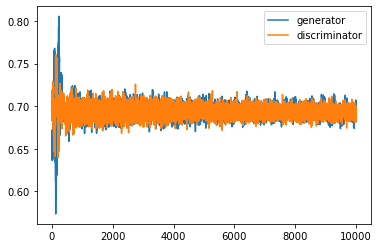

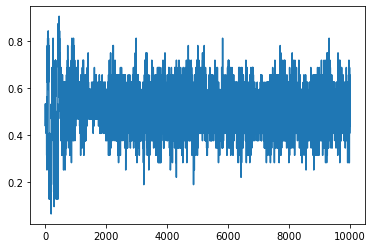

In [53]:
plt.plot(errors_generator, label='generator')
plt.plot(errors_discrim, label='discriminator')
plt.legend()

plt.figure()
plt.plot(perc_discrim)
plt.show()

### Ajustes realizados baseados nas dicas
* Normalizar os inputs entre -1 e 1 (x1 ok, x2 não se aplica)
* Evitar gradientes esparsos: LeakyReLU (estabilidade da GAN)
* Usar SGD para o discriminador
* Usar ADAM para o gerador
* Usar tanh na última camada do gerador
* Adicionar ruído aos inputs ao entrar no discriminador

### Ajustes não realizados
* Amostrar utilizando uma função gaussiana, não uniforme
* Substituir min(log 1-D) por max(log D) na função de perda (evitar vanishing gradients)
* Fazer flips aleatórios durante o treino do discriminador (real=fake, fake=real)
* Se os labels estão disponíveis, classificar usando a GAN auxiliar durante treino do discriminador
* Adicionar ruído gaussiano a cada uma das camadas do gerador